In [1]:
## P1 - Parte Computacional - PSI3471
## Aluno: Leonardo Isao Komura - NUSP: 11261656

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [3]:
# Leitura dos arquivos
ecg_treino = pd.read_pickle("ecg_treino.pickle")
rotulos_treino = pd.read_csv("rotulos_treino.csv")
n_rotulos_treino = pd.read_csv("n_rotulos_treino.csv")  

ecg_teste = pd.read_pickle("ecg_teste.pickle")
rotulos_teste = pd.read_csv("rotulos_teste.csv")
n_rotulos_teste = pd.read_csv("n_rotulos_teste.csv") 

In [4]:
# Transformação em formato numpy
treino = ecg_treino.to_numpy()
r_treino = rotulos_treino.to_numpy()
n_treino = n_rotulos_treino.to_numpy()

teste = ecg_teste.to_numpy()
r_teste = rotulos_teste.to_numpy()
n_teste = n_rotulos_teste.to_numpy()

In [5]:
# Deletando os "nomes" dos pacientes
treino = np.delete(treino, 0, axis=1)
r_treino = np.delete(r_treino, 0, axis=1)
n_treino = np.delete(n_treino, 0, axis=1)

teste = np.delete(teste, 0, axis=1)
r_teste = np.delete(r_teste, 0, axis=1)
n_teste = np.delete(n_teste, 0, axis=1)

In [6]:
# Cálculo da média do "comprimento" dos 1000 primeiros batimentos de todos pacientes
nn = 0.0
for i in range(0, len(n_treino)):
    for j in range(1000):
        nn = nn + abs(n_treino[i,j] - n_treino[i, j+1])
nn_average = math.ceil(nn/(1000*len(n_treino)))
print("Média do comprimento dos 1000 primeiros batimentos de todos pacientes: ", nn_average)

Média do comprimento dos 1000 primeiros batimentos de todos pacientes:  291


In [7]:
# Colocando cada fft de batimento numa posição de um tensor
n_pontos = 420000
batimentos = int(n_pontos/nn_average)
tensor_treino = np.ndarray(shape=(len(treino), batimentos, nn_average+1), dtype=float)
for i in range(len(treino)):
    for j in range(batimentos):
        tensor_treino[i,j] = np.append([0], abs(np.fft.fft(treino[i, int(n_treino[i,j]) : int(n_treino[i,j+1])], n = nn_average)))
        
tensor_teste = np.ndarray(shape=(len(teste), batimentos, nn_average+1), dtype=float)
for i in range(len(teste)):
    for j in range(batimentos):
        tensor_teste[i,j] = np.append([0], abs(np.fft.fft(teste[i, int(n_teste[i,j]) : int(n_teste[i,j+1])], n = nn_average)))

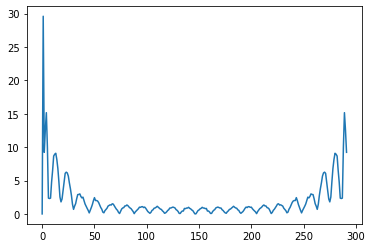

In [8]:
plt.plot(tensor_treino[12,1])

In [9]:
# Cálculo da média do "comprimento" de 3 batimentos
for i in range(len(n_treino)):
    for j in range(batimentos):
        nn = 0.0
        if(j == 0):
            for k in range(3):
                nn = nn + abs(n_treino[i,k] - n_treino[i, k+1])
            nn_average = nn/3
            tensor_treino[i,j,0] = nn_average
        elif(j == batimentos-1):
            for k in range(batimentos-4, batimentos-1):
                nn = nn + abs(n_treino[i,k] - n_treino[i, k+1])
            nn_average = nn/3
            tensor_treino[i,j,0] = nn_average
        else:
            for k in range(3):
                nn = nn + abs(n_treino[i,k+j-1] - n_treino[i, k+j])
            nn_average = nn/3
            tensor_treino[i,j,0] = nn_average
 
for i in range(len(n_teste)):
    for j in range(batimentos):
        nn = 0.0
        if(j == 0):
            for k in range(3):
                nn = nn + abs(n_teste[i,k] - n_teste[i, k+1])
            nn_average = nn/3
            tensor_teste[i,j,0] = nn_average
        elif(j == batimentos-1):
            for k in range(batimentos-4, batimentos-1):
                nn = nn + abs(n_teste[i,k] - n_teste[i, k+1])
            nn_average = nn/3
            tensor_teste[i,j,0] = nn_average
        else:
            for k in range(3):
                nn = nn + abs(n_teste[i,k+j-1] - n_teste[i, k+j])
            nn_average = nn/3
            tensor_teste[i,j,0] = nn_average   

In [10]:
# Transformando um tensor numa matriz (cada linha refere-se a fft de um batimento + media)
matriz_treino = np.zeros((batimentos*len(treino), len(tensor_treino[0,0])))
n = 0
for i in range(len(treino)):
    for j in range(batimentos):
        matriz_treino[n] = tensor_treino[i,j]
        n = n+1

matriz_teste = np.zeros((batimentos*len(teste), len(tensor_teste[0,0])))
n = 0
for i in range(len(teste)):
    for j in range(batimentos):
        matriz_teste[n] = tensor_teste[i,j]
        n = n+1

In [11]:
dados_treino = pd.DataFrame(matriz_treino)
df_teste = pd.DataFrame(matriz_teste)

In [12]:
# Criando a matriz de rótulos binária
matriz_rotulos_treino_2 = np.zeros((batimentos*len(treino),1))
n = 0
for i in range(len(treino)):
    for j in range(batimentos):
        if(r_treino[i,j] == "N"):
            x = 0
        else: x = 1
        matriz_rotulos_treino_2[n,0] = x
        n = n+1
        
matriz_rotulos_teste_2 = np.zeros((batimentos*len(teste),1))
n = 0
for i in range(len(teste)):
    for j in range(batimentos):
        if(r_treino[i,j] == "N"):
            x = 0
        else: x = 1
        matriz_rotulos_teste_2[n,0] = x
        n = n+1

In [13]:
df_r_treino_2 = pd.DataFrame(matriz_rotulos_treino_2)
df_r_teste_2 = pd.DataFrame(matriz_rotulos_teste_2)

In [14]:
# SMOTE
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
oversample = SMOTE()
df_treino, df_r_treino_2 = oversample.fit_resample(dados_treino, df_r_treino_2)

In [15]:
# Validação cruzada
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(df_treino, df_r_treino_2, test_size = 0.1, random_state=1)
print('Qtde de treino: {}'.format(len(x_train)))
print('Qtde de validação: {}'.format(len(x_val)))

Qtde de treino: 51697
Qtde de validação: 5745


In [16]:
# Criando a MLP
model = Sequential()
model.add(Dense(300, activation='relu', input_shape=(len(matriz_treino[0]),)))
model.add(Dropout(0.2))
model.add(Dense(300, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [17]:
batch_size = 500
epochs = 10
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val))

Epoch 1/10
104/104 [==============================] - 3s 17ms/step - loss: 0.6960 - accuracy: 0.7054 - val_loss: 0.3990 - val_accuracy: 0.8433
Epoch 2/10
104/104 [==============================] - 1s 14ms/step - loss: 0.3542 - accuracy: 0.8545 - val_loss: 0.2827 - val_accuracy: 0.8994
Epoch 3/10
104/104 [==============================] - 1s 14ms/step - loss: 0.2784 - accuracy: 0.8908 - val_loss: 0.2203 - val_accuracy: 0.9196
Epoch 4/10
104/104 [==============================] - 1s 14ms/step - loss: 0.2362 - accuracy: 0.9089 - val_loss: 0.2051 - val_accuracy: 0.9258
Epoch 5/10
104/104 [==============================] - 2s 15ms/step - loss: 0.2041 - accuracy: 0.9225 - val_loss: 0.1715 - val_accuracy: 0.9305
Epoch 6/10
104/104 [==============================] - 2s 15ms/step - loss: 0.1899 - accuracy: 0.9274 - val_loss: 0.1635 - val_accuracy: 0.9427
Epoch 7/10
104/104 [==============================] - 2s 15ms/step - loss: 0.1721 - accuracy: 0.9355 - val_loss: 0.1628 - val_accuracy: 0.9426

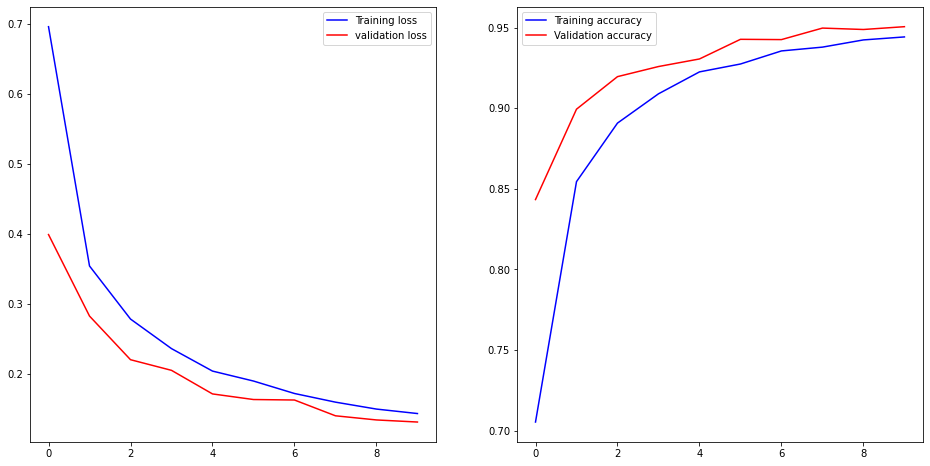

In [18]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=False)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=False)


In [19]:
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

993/993 [==============================] - 2s 1ms/step
Classification Report
              precision    recall  f1-score   support

           0       0.68      0.91      0.78     21567
           1       0.34      0.10      0.15     10179

    accuracy                           0.65     31746
   macro avg       0.51      0.50      0.47     31746
weighted avg       0.57      0.65      0.58     31746



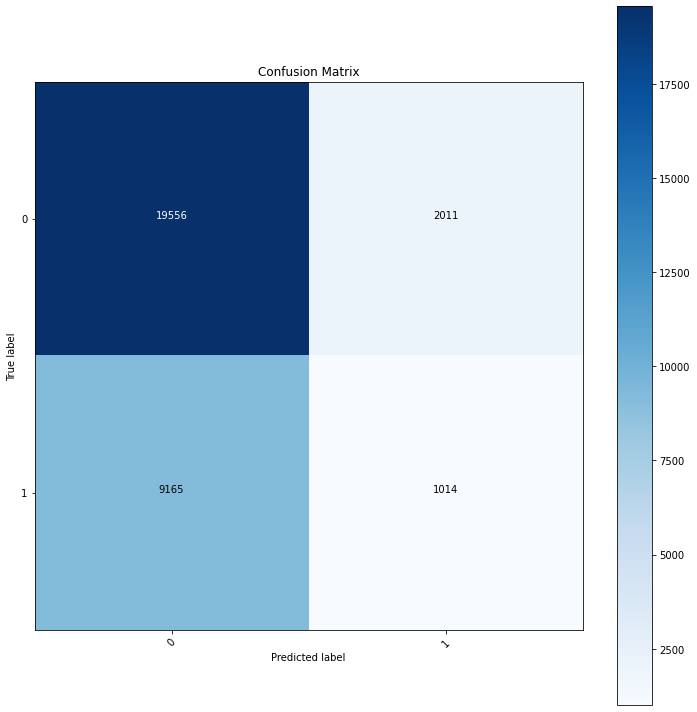

In [20]:
target_names = ['0', '1']
r_teste_2 = (model.predict(df_teste) > 0.5)
cm = confusion_matrix(r_teste_2, df_r_teste_2)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')

print('Classification Report')
print(classification_report(r_teste_2, df_r_teste_2, target_names=target_names))


In [21]:
# Criando a matriz de rótulos multiclasse
matriz_rotulos_treino_m = np.zeros((batimentos*len(treino),1))

n = 0
for i in range(len(treino)):
    for j in range(batimentos):
        if(r_treino[i,j] == 'N'):
            x = 0
        elif(r_treino[i,j] == 'S'):
            x = 1
        elif(r_treino[i,j] == 'V'):
            x = 2
        else: x = 0
        matriz_rotulos_treino_m[n,0] = x
        n = n+1
        
matriz_rotulos_teste_m = np.zeros((batimentos*len(teste),1))
n = 0
for i in range(len(teste)):
    for j in range(batimentos):
        if(r_treino[i,j] == 'N'):
            x = 0
        elif(r_treino[i,j] == 'S'):
            x = 1
        elif(r_treino[i,j] == 'V'):
            x = 2
        else: x = 0
        matriz_rotulos_teste_m[n,0] = x
        n = n+1

In [22]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
rotulos_treino_m = np.ravel(matriz_rotulos_treino_m)
y = LabelEncoder().fit_transform(rotulos_treino_m)
yt = np.reshape(y, [-1,1])

df_r_teste_m = pd.DataFrame(np.reshape(LabelEncoder().fit_transform(np.ravel(matriz_rotulos_teste_m)), [-1,1]))


In [23]:
# SMOTE
oversample = SMOTE(k_neighbors=2)
df_treino_m, df_r_treino_m = oversample.fit_resample(dados_treino, pd.DataFrame(yt))

Class=0, n=28997 (33.333%)
Class=1, n=28997 (33.333%)
Class=2, n=28997 (33.333%)


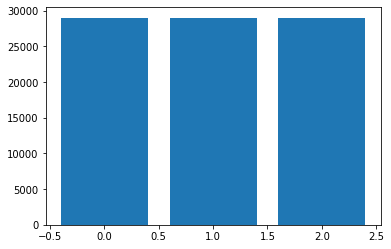

In [24]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
y = np.ravel(df_r_treino_m)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(df_r_treino_m) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [25]:
# Validação cruzada
x_train, x_val, y_train1, y_val1 = train_test_split(df_treino_m, df_r_treino_m, test_size = 0.1, random_state=1)
print('Qtde de treino: {}'.format(len(x_train)))
print('Qtde de validação: {}'.format(len(x_val)))

Qtde de treino: 78291
Qtde de validação: 8700


In [26]:
y_train = pd.get_dummies(y_train1[0])
y_val = pd.get_dummies(y_val1[0])
y_test = pd.get_dummies(df_r_teste_m[0])

In [27]:
model_m = Sequential()
model_m.add(Dense(300, activation='relu', input_shape=(len(matriz_treino[0]),)))
model_m.add(Dropout(0.2))
model_m.add(Dense(300, activation='relu'))
model_m.add(Dropout(0.2))
model_m.add(Dense(200, activation='relu'))
model_m.add(Dropout(0.2))
model_m.add(Dense(200, activation='relu'))
model_m.add(Dropout(0.2))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dropout(0.2))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dropout(0.2))
model_m.add(Dense(3, activation='softmax'))

model_m.compile(loss='binary_crossentropy',
              optimizer="Adam",
              metrics=['accuracy'])

In [28]:
batch_size = 500
epochs = 10
history = model_m.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_val, y_val))

Epoch 1/10
157/157 [==============================] - 3s 15ms/step - loss: 0.4657 - accuracy: 0.6601 - val_loss: 0.2613 - val_accuracy: 0.8214
Epoch 2/10
157/157 [==============================] - 2s 15ms/step - loss: 0.2527 - accuracy: 0.8367 - val_loss: 0.1716 - val_accuracy: 0.8978
Epoch 3/10
157/157 [==============================] - 2s 15ms/step - loss: 0.1819 - accuracy: 0.8901 - val_loss: 0.1233 - val_accuracy: 0.9259
Epoch 4/10
157/157 [==============================] - 2s 13ms/step - loss: 0.1443 - accuracy: 0.9183 - val_loss: 0.0996 - val_accuracy: 0.9443
Epoch 5/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1237 - accuracy: 0.9312 - val_loss: 0.0911 - val_accuracy: 0.9489
Epoch 6/10
157/157 [==============================] - 2s 14ms/step - loss: 0.1078 - accuracy: 0.9408 - val_loss: 0.0838 - val_accuracy: 0.9522
Epoch 7/10
157/157 [==============================] - 2s 14ms/step - loss: 0.0961 - accuracy: 0.9482 - val_loss: 0.0734 - val_accuracy: 0.9595

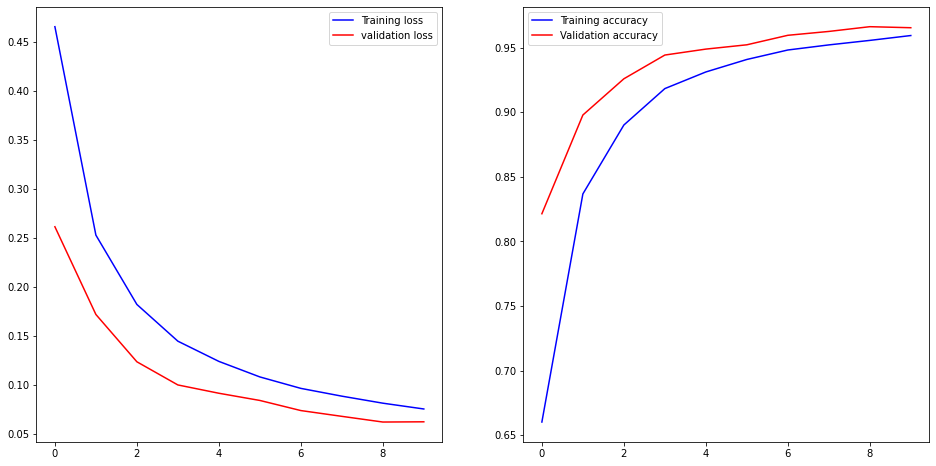

In [29]:
fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=False)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=False)

993/993 [==============================] - 1s 1ms/step
Classification Report
              precision    recall  f1-score   support

           N       0.72      0.93      0.81     22501
           S       0.19      0.02      0.04      5264
           V       0.18      0.10      0.13      3981

    accuracy                           0.67     31746
   macro avg       0.36      0.35      0.32     31746
weighted avg       0.56      0.67      0.60     31746



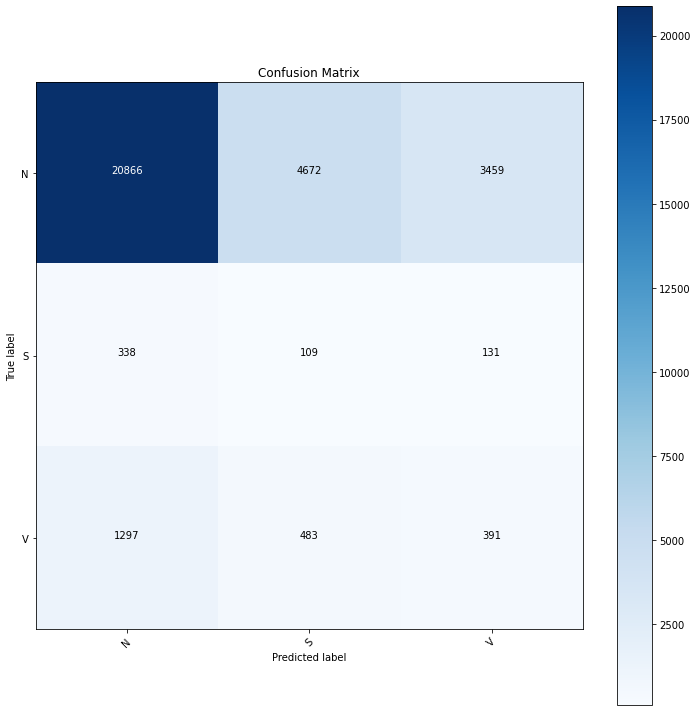

In [30]:
target_names = ['N', 'S', 'V']
r_teste_m = model_m.predict(df_teste)
y_test_c = np.argmax(y_test.to_numpy(), axis=1)
r_teste_m_c = np.argmax(r_teste_m, axis=1)
cm = confusion_matrix(y_test_c, r_teste_m_c)
plot_confusion_matrix(cm, target_names, normalize=False, title='Confusion Matrix')
print('Classification Report')
print(classification_report(r_teste_m_c, y_test_c, target_names=target_names))
